In [1]:
# Setting up
!pip install transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
# For data visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# For DistilBERT and BERT
from transformers import DistilBertTokenizer, DistilBertModel
from transformers import BertTokenizer, BertModel

# For cosine similarity
import torch
import torch.nn.functional as F

# For monitoring the process
from tqdm import tqdm

Import the dataset from hugingface.

In [3]:
splits = {'train': 'train.csv', 'test': 'test.csv'}
df = pd.read_csv("hf://datasets/cnamuangtoun/resume-job-description-fit/" + splits["train"])
df.shape

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


(6241, 3)

In [ ]:
df.head()

,resume_text,job_description_text,label
0,SummaryHighly motivated Sales Associate with e...,Net2Source Inc. is an award-winning total work...,No Fit
1,Professional SummaryCurrently working with Cat...,At Salas OBrien we tell our clients that were ...,No Fit
2,SummaryI started my construction career in Jun...,Schweitzer Engineering Laboratories (SEL) Infr...,No Fit
3,SummaryCertified Electrical Foremanwith thirte...,"Mizick Miller & Company, Inc. is looking for a...",No Fit
4,SummaryWith extensive experience in business/r...,Life at Capgemini\nCapgemini supports all aspe...,No Fit


Inspect the dataset to see if there's any missing value (practicing the use of heatmap)

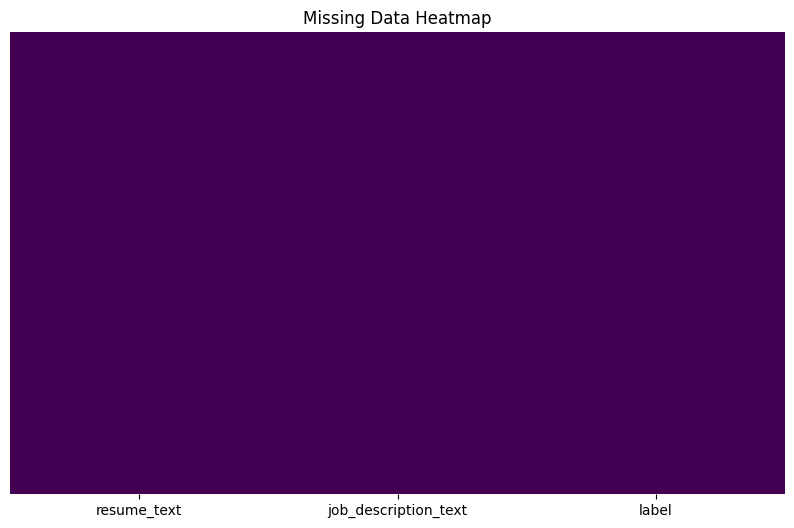

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), cmap="viridis", cbar=False, yticklabels=False)
plt.title("Missing Data Heatmap")
plt.show()

This session provides an overview of model options. I will select two models: one for fine-tuning practice and another as a comparison benchmark.

| Model Name | Best For | Pros | Cons |
| --- | --- | --- | --- |
| BERT (bert-base-uncased)  | Text classification, entity recognition, text similarity | Strong baseline, widely used, lots of resources available | Can be slow for real-time applications |
| RoBERTa (roberta-base) | Improved text understanding, ranking tasks | More robust than BERT, handles longer text better | Larger model size |
| DistilBERT (distilbert-base-uncased) | Faster version of BERT for classification and ranking | Smaller, faster, still retains good accuracy | Slightly less powerful than full BERT |
| GPT-3.5 / GPT-4 (via API) | Advanced language tasks, resume/job matching, chatbots | Extremely powerful, few-shot learning | Expensive, requires API calls (not open-source) |

The overall structure of this ATS mock-up has two layers (high level). Since my goal is to know the percentage of resume-job description matching, the approach would be measuring the cosine similarity.
 - First layer: DistilBERT
 - Second layer: The cosine similarity function.

[See the underlying working of models like BERT here.](https://www.youtube.com/watch?v=GDN649X_acE)


# Step 1: Load the model and the tokenizer
The model in the first layer serves as a base model, which generates the embeddings from the tensor representation of the text input.

Tokenizer turns text input into its tensor representation (tokenization).

In [4]:
# Load pre-trained DistilBERT tokenizer and model
tokenizer_distill = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model_distill = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Load pre-trained BERT tokenizer and model
tokenizer_BERT = BertTokenizer.from_pretrained("bert-base-uncased")
model_BERT = BertModel.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Since this ATS mock-up gives the percentage of resume-job description matching, a [consine similarity](https://www.youtube.com/watch?v=e9U0QAFbfLI) function layer would be added on top of the base model.

# Step 2: Understand dot product (similarity) of vectors and normalization.
[The dot product](https://betterexplained.com/articles/vector-calculus-understanding-the-dot-product/) of these two normalized tensors gives an idea of the **similarity**. In simple, we care about the add up of directional component horizontally, not perpendicularly. (Refer to the Mario cart analogy in the linked video)
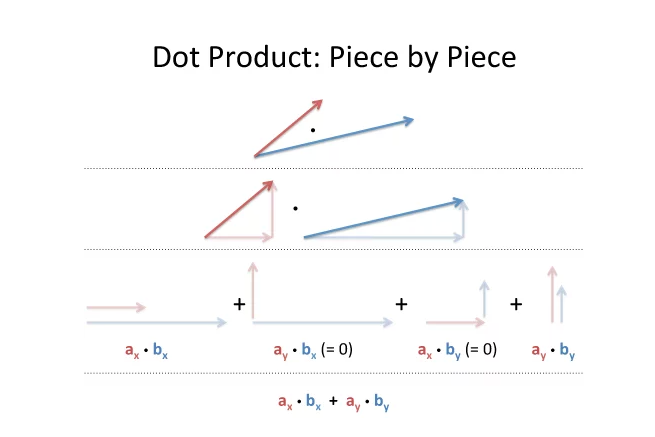

Notice how $a_x b_x$, $a_x b_y$, $a_y b_y$, and $a_y b_x$ act just like $\cos(\theta)$ of these two vectors.


The reason why we nomalized these two tensors is to get rid of the effect caused by their magnitudes (see the figure below or refer to the linked video for a better understanding)

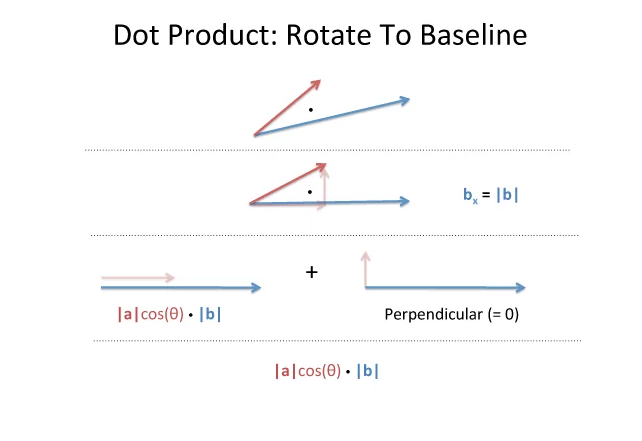

Notice how $|\vec{a}| \cos(\theta) |\vec{b}| = \cos(\theta)$ when $a$ and $b$ are normalized ($|\vec{a}| = |\vec{b}| = 1$).
The reason why I mentioned dot product here is because I'll be calculating the similarity of all rows of the dataframe. Instead of loop thru nearly 6000 rows and calculate it one at a time, I put all `resume_text` as a matrix and `job_description_text` as another matrix, and then compute their dot product.

# Step 3: Define function to wrap layers together
Here I'll just call them match_distill and match_BERT, respectively.

In [5]:
def match_distill(resume, job_description):
    # Convert input lists to GPU-compatible format
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Tokenize inputs and move to GPU
    tokenized_resumes = tokenizer_distill(resume, return_tensors="pt", padding=True, truncation=True, max_length=512)
    tokenized_jobs = tokenizer_distill(job_description, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Move to GPU
    tokenized_resumes = {key: val.to(device) for key, val in tokenized_resumes.items()}
    tokenized_jobs = {key: val.to(device) for key, val in tokenized_jobs.items()}

    # Move model to GPU
    model_distill.to(device)

    with torch.no_grad():

      # The output would look like a 2D tensor; each of them represents the meaning of the whole input
      output_resumes = model_distill(**tokenized_resumes)
      output_jobs = model_distill(**tokenized_jobs)

    embeddings_resumes = output_resumes.last_hidden_state[:, 0, :] # Shape: (1, hidden_size)
    embeddings_jobs = output_jobs.last_hidden_state[:, 0, :] # Shape: (1, hidden_size)

    # Normalize embeddings to speed up cosine similarity calculation
    normalized_resumes = F.normalize(embeddings_resumes, p=2, dim=1)
    normalized_jobs = F.normalize(embeddings_jobs, p=2, dim=1)

    # Compute cosine similarity in one batch operation
    similarity_matrix = torch.mm(normalized_resumes, normalized_jobs.T)  # Faster than F.cosine_similarity

    return similarity_matrix.cpu().numpy()

In [6]:
def match_BERT(resume, job_description):
    # Convert input lists to GPU-compatible format
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Tokenize inputs and move to GPU
    tokenized_resumes = tokenizer_BERT(resume, return_tensors="pt", padding=True, truncation=True, max_length=512)
    tokenized_jobs = tokenizer_BERT(job_description, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Move to GPU
    tokenized_resumes = {key: val.to(device) for key, val in tokenized_resumes.items()}
    tokenized_jobs = {key: val.to(device) for key, val in tokenized_jobs.items()}

    # Move model to GPU
    model_BERT.to(device)

    with torch.no_grad():
      output_resumes = model_BERT(**tokenized_resumes)
      output_jobs = model_BERT(**tokenized_jobs)

    embeddings_resumes = output_resumes.last_hidden_state[:, 0, :] # Shape: (1, hidden_size)
    embeddings_jobs = output_jobs.last_hidden_state[:, 0, :] # Shape: (1, hidden_size)

    # Normalize embeddings to speed up cosine similarity calculation
    normalized_resumes = F.normalize(embeddings_resumes, p=2, dim=1)
    normalized_jobs = F.normalize(embeddings_jobs, p=2, dim=1)

    # Compute cosine similarity in one batch operation
    similarity_matrix = torch.mm(normalized_resumes, normalized_jobs.T)  # Faster than F.cosine_similarity

    return similarity_matrix.cpu().numpy()

# Step 4: Call the function on each rows of the dataframe and store thm into a list.
Now I'll feed the inputs to the base model (without fine-tuning it) and compare it with BERT as the comparison benchmark.

In [7]:
batch_size = 256
all_similarities_distill = []
all_similarities_BERT = []

resume_list = df['resume_text'].astype(str).tolist()
job_list = df['job_description_text'].astype(str).tolist()

for i in tqdm(range(0, len(resume_list), batch_size), desc="Processing batches", ncols=100, unit="batch"):
    batch_resumes = resume_list[i : i + batch_size]
    batch_jobs = job_list[i : i + batch_size]

    batch_similarities_distill = match_distill(batch_resumes, batch_jobs)
    all_similarities_distill.extend(batch_similarities_distill)

    batch_similarities_BERT = match_BERT(batch_resumes, batch_jobs)
    all_similarities_BERT.extend(batch_similarities_BERT)



Processing batches: 100%|████████████████████████████████████████| 25/25 [15:40<00:00, 37.62s/batch]


The averaged matching scores in the first vectors of both tensors are enough to see their performance.

In [8]:
print(f'Averaged Similarity Score - BERT: {np.mean(all_similarities_distill[0])}')
print(f'Averaged Similarity Score - DistilBERT: {np.mean(all_similarities_BERT[0])}')

Averaged Similarity Score - BERT: 0.9349167346954346
Averaged Similarity Score - DistilBERT: 0.8227648735046387


A it indicates, BERT outperforms DistilBERT, meaning that we should fine-tune DistilBERT if I want to use that model to have better similarity score.

# Step 5: Fine tune DistilBERT

In [ ]:
# Future work.

All the work above are solely for knowing if we should fine-tune DistilBERT. For now I'll just call `match_BERT` to see the matching score. (Once distilBERT is fine-tuend, I'll change back to that model)

In [11]:
resume = df['resume_text'][5]
job = df['job_description_text'][5]

score = match_BERT(resume, job)
print(f'Matching Score: {score}')

Matching Score: [[0.7360282]]


As we can see below, the label on the fifth row is No Fit.

In [12]:
df.head(5)

,resume_text,job_description_text,label
0,SummaryHighly motivated Sales Associate with e...,Net2Source Inc. is an award-winning total work...,No Fit
1,Professional SummaryCurrently working with Cat...,At Salas OBrien we tell our clients that were ...,No Fit
2,SummaryI started my construction career in Jun...,Schweitzer Engineering Laboratories (SEL) Infr...,No Fit
3,SummaryCertified Electrical Foremanwith thirte...,"Mizick Miller & Company, Inc. is looking for a...",No Fit
4,SummaryWith extensive experience in business/r...,Life at Capgemini\nCapgemini supports all aspe...,No Fit
